In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,cross_val_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
plt.style.use("seaborn")
warnings.filterwarnings('ignore')

In [3]:
# importing the train and test datasets
comments_data = pd.read_csv("/content/drive/MyDrive/toxic_comment_data/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/toxic_comment_data/test.csv")
comments_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


# Data Preprocessing

In [63]:
comments_data.isnull().sum() 

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [44]:
test_data.isnull().sum()

id              0
comment_text    0
dtype: int64



> Data Pre-processing



In [45]:
# dropping the columns containing almost all null values
colmns1 = comments_data.columns.values[0:1]
colmns2 = comments_data.columns.values[8:-3]
colmns3 = comments_data.columns.values[-2:]

comments_data.drop(colmns2,axis=1,inplace=True)
comments_data.drop(colmns1,axis=1,inplace=True)
comments_data.drop(colmns3,axis=1,inplace=True)

comments_data.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,0.0
1,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,0.0
2,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,0.0
3,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,0.0
4,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0


In [ ]:
# random selection of data in batches
import random
batch_size = 200000
data_1 = comments_data[comments_data["target"] < 0.4]
data_2 = comments_data[comments_data["target"] >= 0.4]
n_rows = comments_data.shape[0]
n_rows1 = data_1.shape[0]
n_rows2 = data_2.shape[0]

random_idx1 = random.sample(range(n_rows1),batch_size)
random_idx2 = random.sample(range(n_rows2),batch_size)


data_1 = comments_data.values[random_idx1,:]
data_2 = comments_data.values[random_idx2,:]

In [ ]:
# combining the data into dataframe
data_1 = pd.DataFrame(data_1,columns=comments_data.columns.values)
data_2 = pd.DataFrame(data_2,columns=comments_data.columns.values)
comments_data = pd.concat([data_1,data_2],ignore_index=True,axis=0)
comments_data = comments_data.sample(frac=1)
comments_data.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
14329,0.0,parthogenesis?,0.0,0.0,0.0,0.0,0.0,0.0
358610,0.4,Your blanket statement about any aspect of pol...,0.1,0.1,0.2,0.2,0.1,0.1
91669,0.2,"Well,for starters we could cite the emoluments...",0.0,0.0,0.1,0.3,0.0,0.0
106200,0.0,"Before that, there was news and commentary by ...",0.0,0.0,0.0,0.0,0.0,0.0
353984,0.0,Was a terrible tragedy. But do any of the peop...,0.0,0.0,0.0,0.0,0.0,0.0


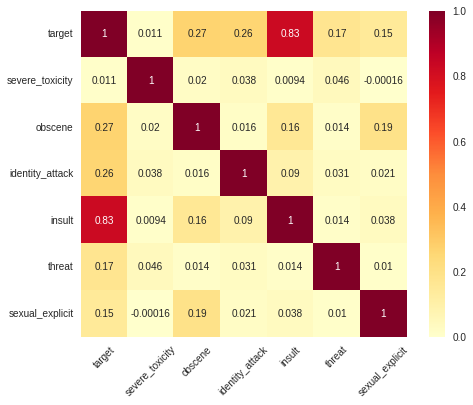

In [ ]:
# heatmap of the labels 
fig = plt.figure(figsize=(8,6))
corr_mat = comments_data.drop(["comment_text"],axis=1).corr()
sns.heatmap(corr_mat,annot=True,cmap='YlOrRd',square=True)
plt.xticks(rotation = 45,fontsize = 10)
plt.show()



> Data Visualization



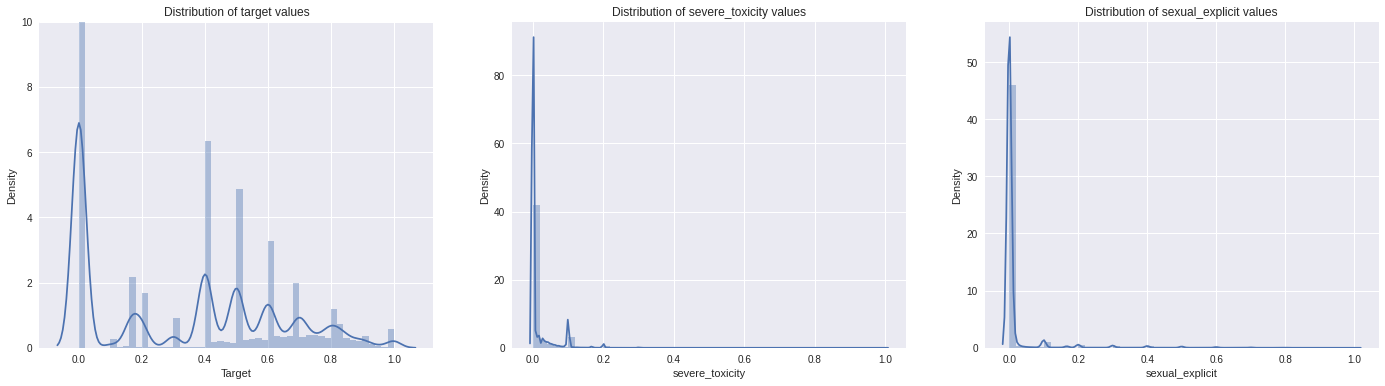

In [ ]:
fig = plt.figure(figsize=(24,6))

plt.subplot(131)
sns.distplot(comments_data["target"])
plt.ylim(0,10)
plt.xlabel("Target")
plt.title("Distribution of target values")

plt.subplot(132)
sns.distplot(comments_data["severe_toxicity"])
plt.xlabel("severe_toxicity")
plt.title("Distribution of severe_toxicity values")

plt.subplot(133)
sns.distplot(comments_data["sexual_explicit"])
plt.xlabel("sexual_explicit")
plt.title("Distribution of sexual_explicit values")

plt.show()

In [ ]:
comments_data.shape

(400000, 8)

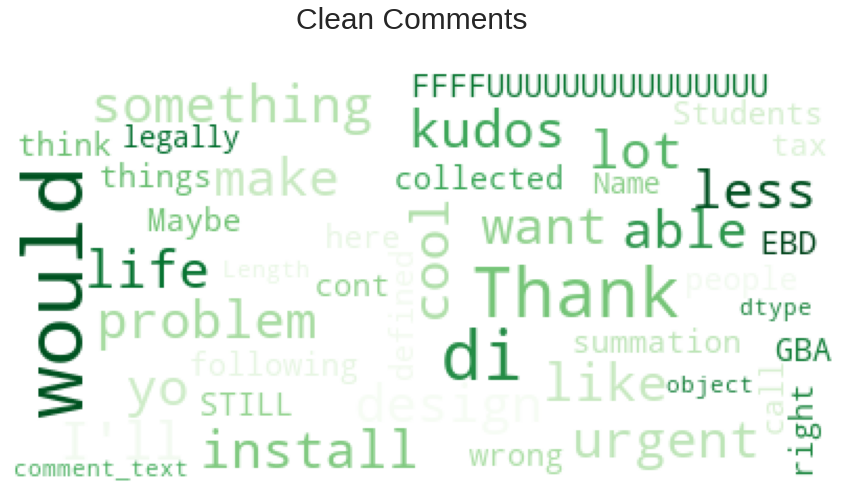

In [ ]:
from wordcloud import WordCloud

pos_comments = comments_data[comments_data["target"] <= 0.2].comment_text
# pos_comments = pos_comments.apply(wordopt)
wordcloud = WordCloud(background_color='white',
                      stopwords=set(stopwords.words('english')),
                      max_words=100,
                      max_font_size=40,
                      colormap='Greens'
                         ).generate(str(pos_comments))
plt.figure('wordcloud', figsize=(15,8))
plt.suptitle('Clean Comments', fontsize=30)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

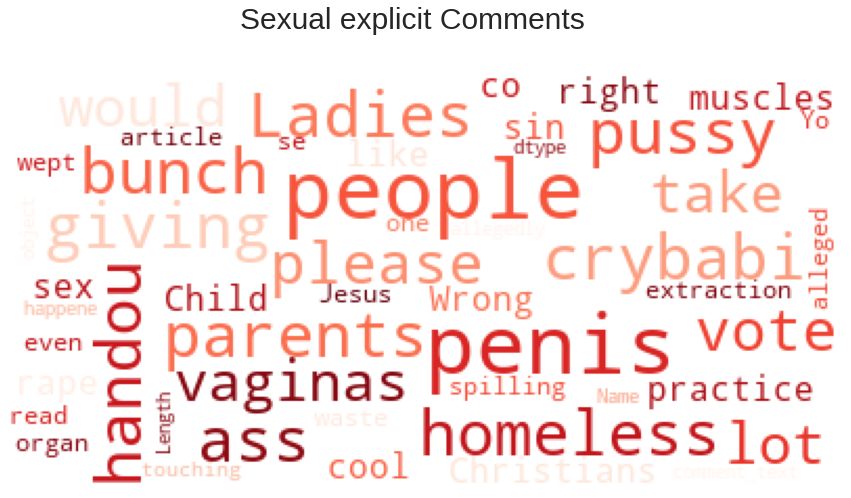

In [54]:
from wordcloud import WordCloud
# for label in comments_data.drop(["comment_text"],axis=1).columns[1:]:
pos_comments = comments_data[comments_data["sexual_explicit"] > 0.7].comment_text
# pos_comments = pos_comments.apply(wordopt)
wordcloud = WordCloud(background_color='white',
                      stopwords=set(stopwords.words('english')),
                      max_words=100,
                      max_font_size=40,
                      colormap='Reds'
                        ).generate(str(pos_comments))
plt.figure('wordcloud', figsize=(15,8))
plt.suptitle('Sexual explicit Comments', fontsize=30)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# function to find the count of words
def get_word_cnt(tokens):
    count_words = [(k, v) for k, v in zip(tokens.word_counts.keys(), tokens.word_counts.values())]
    count_words.sort(key = lambda tup: tup[1], reverse=True)
    stop_words = set(stopwords.words('english'))
    words_count = [tup for tup in count_words if tup[0] not in stop_words]
    return words_count

# function to plot the counts of top words in comments
def word_plot(words_count, total_words, title):
    plt.figure(title, figsize=(23, 8))
    plt.suptitle(title, fontsize=30)
    sns.barplot(x= [tup[0] for tup in words_count[0:total_words]], y = [tup[1] for tup in words_count[0:total_words]])
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18, rotation=35, ha='right')
    plt.show()

In [ ]:
# converting the continuous values of labels into classes using threshold as 0.5
comments_data["target"] = comments_data["target"].apply(lambda x : 1 if x >= 0.5 else 0)
for feat in comments_data.columns.values[2:]:
  comments_data[feat] = comments_data[feat].apply(lambda x : 1 if x >= 0.5 else 0)

comments_data.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
14329,0,parthogenesis?,0,0,0,0,0,0
358610,0,Your blanket statement about any aspect of pol...,0,0,0,0,0,0
91669,0,"Well,for starters we could cite the emoluments...",0,0,0,0,0,0
106200,0,"Before that, there was news and commentary by ...",0,0,0,0,0,0
353984,0,Was a terrible tragedy. But do any of the peop...,0,0,0,0,0,0


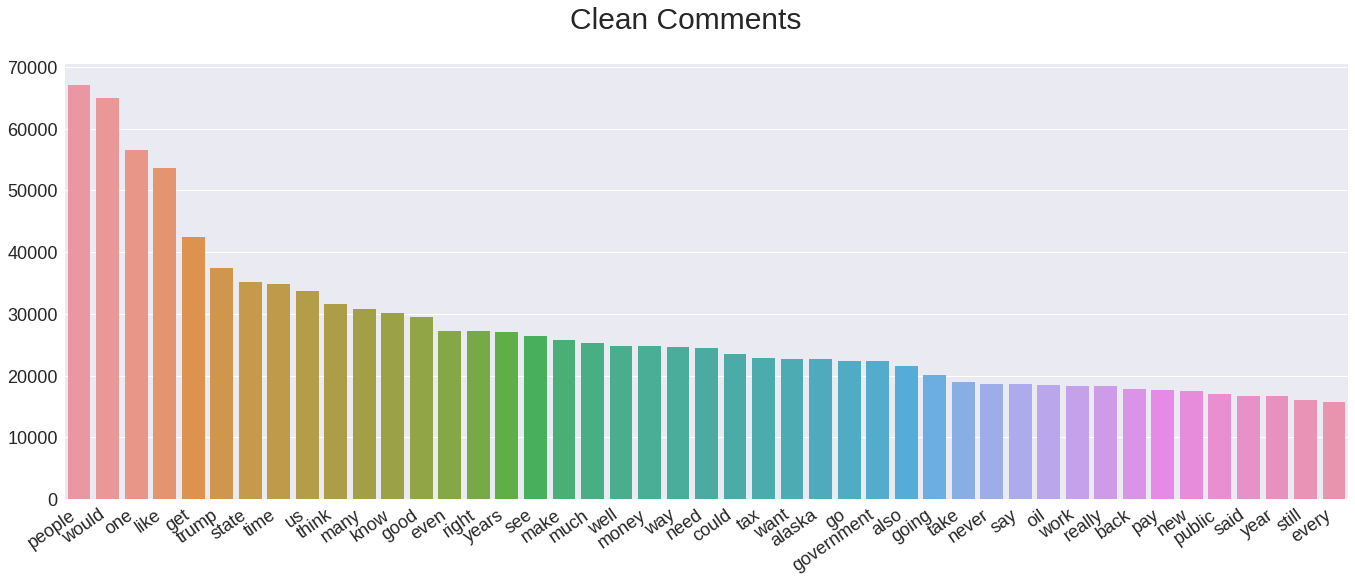

In [ ]:
# plotting the counts of clean comments in data
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

tokenizer_text = Tokenizer(filters=string.punctuation+'\n', lower=True)
tokenizer_text.fit_on_texts(comments_data[comments_data["target"] == 0].comment_text)
word_plot(get_word_cnt(tokenizer_text), 45, 'Clean Comments')

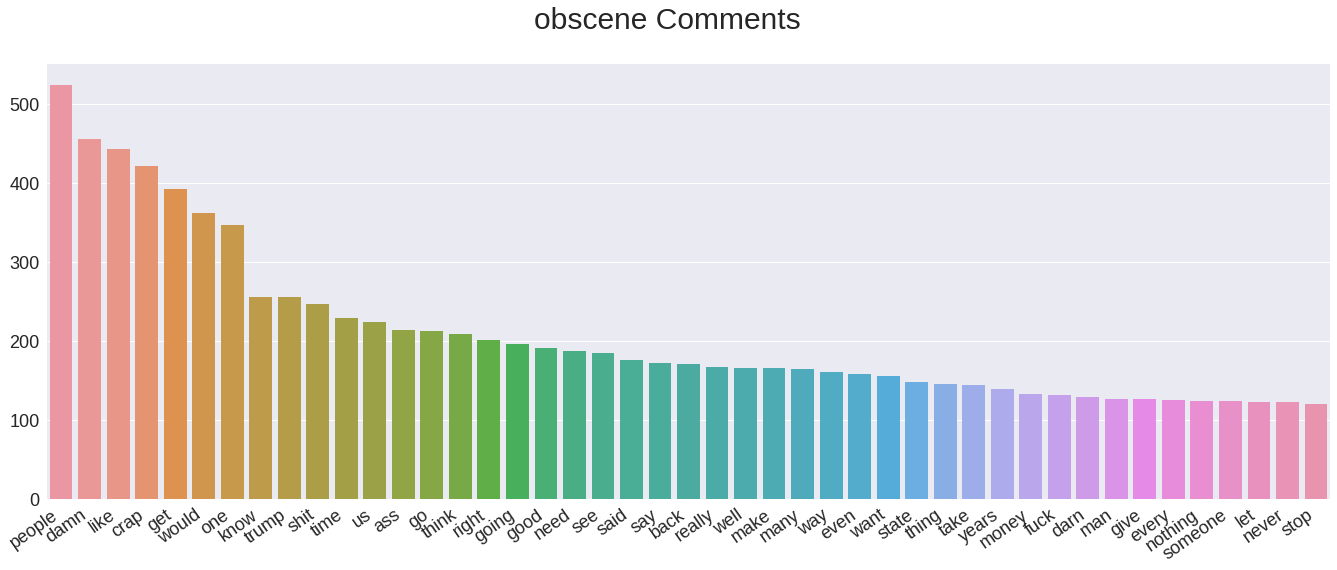

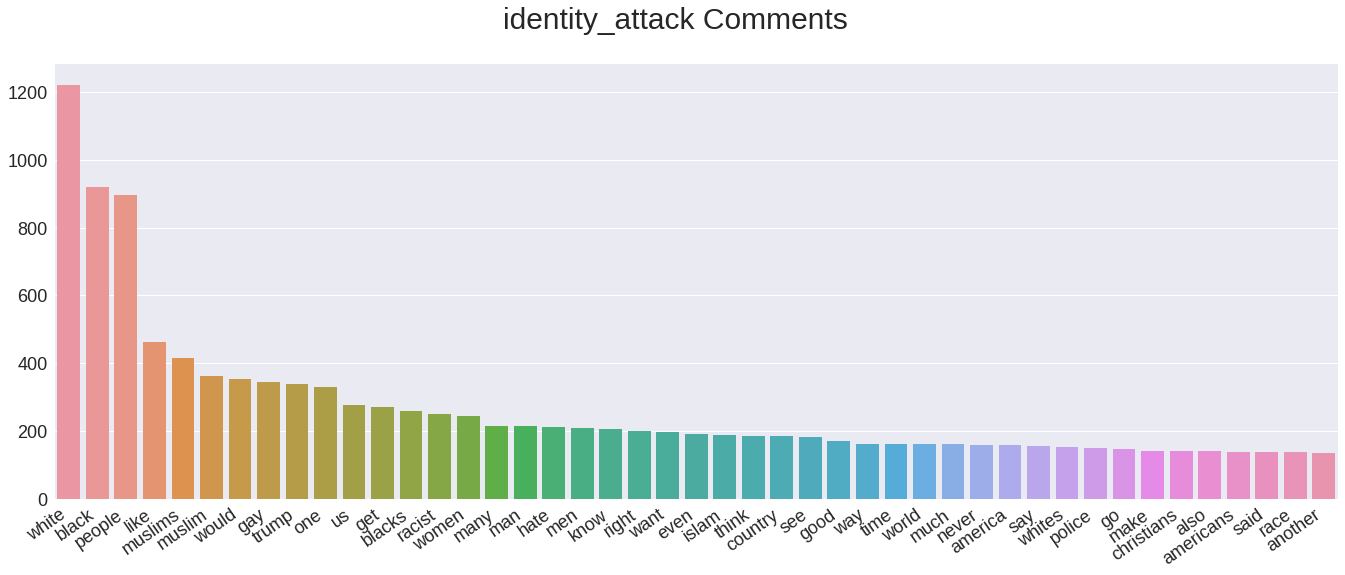

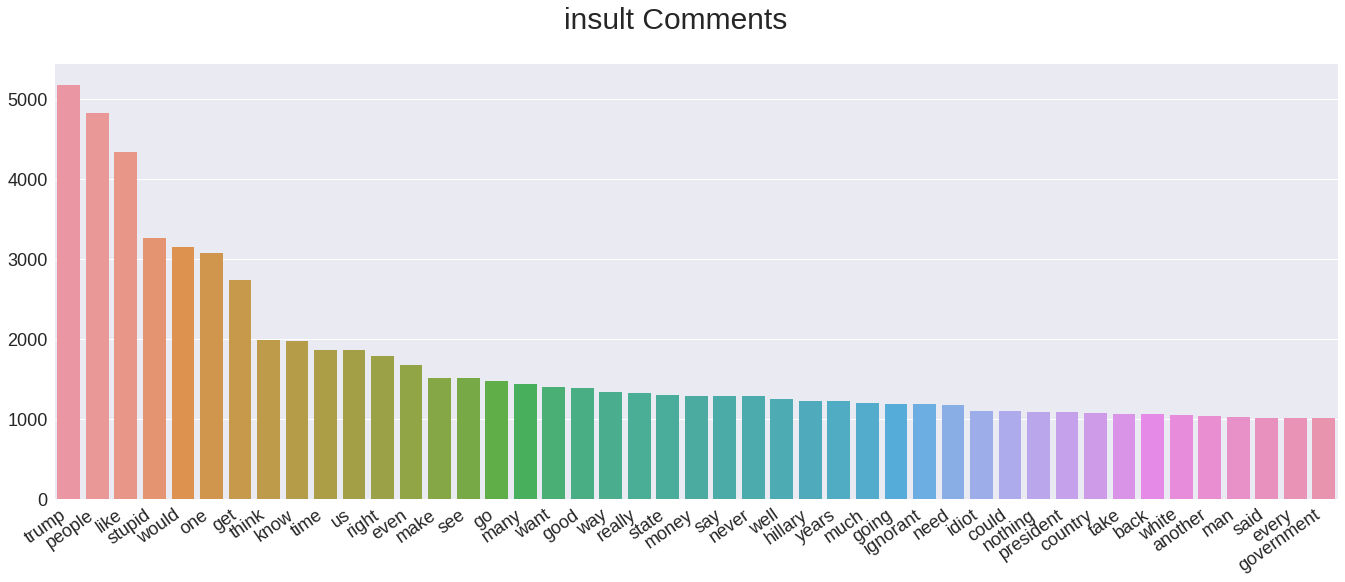

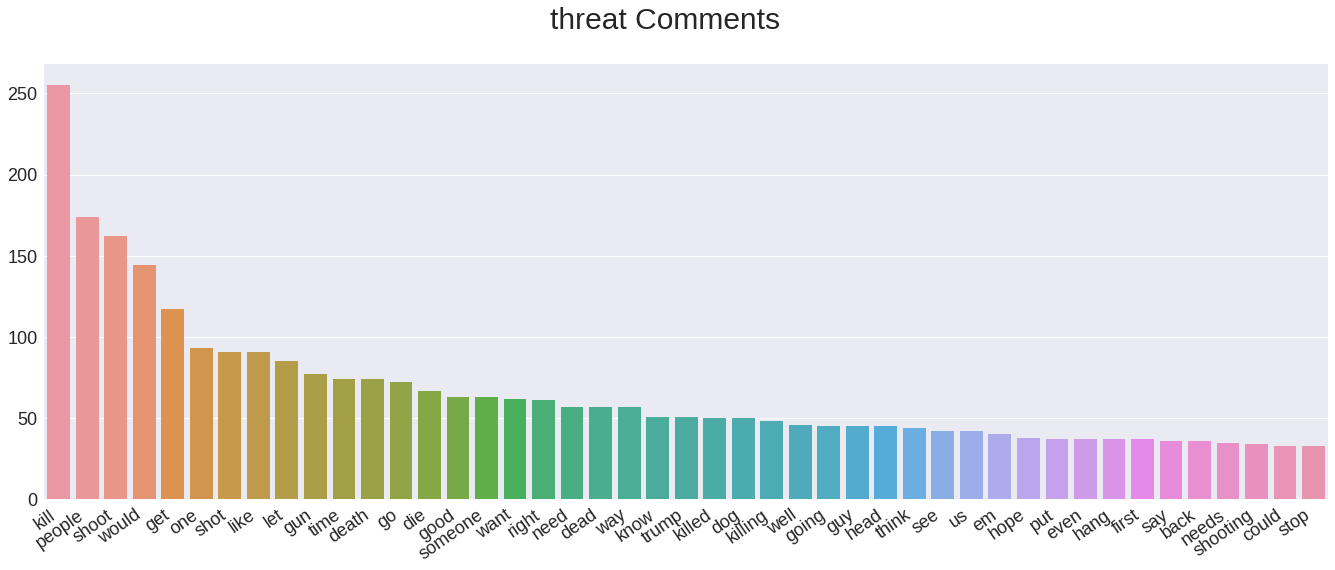

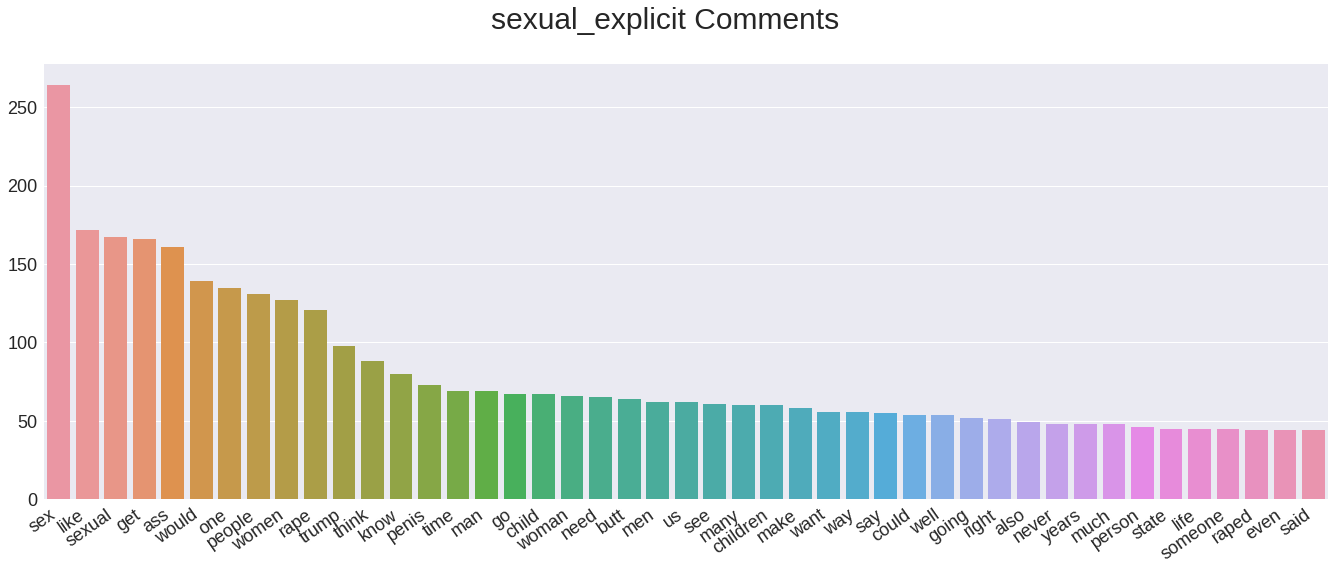

In [ ]:
# plotting the top words from label columns in dataset
for label in comments_data.columns.values[3:]:
    tokenizer_toxic = Tokenizer(filters=string.punctuation+'\n', lower=True)
    tokenizer_toxic.fit_on_texts(comments_data[comments_data[label] == 1].comment_text)
    word_plot(get_word_cnt(tokenizer_toxic), 45, label + ' Comments')



# Performing NLP on data  



In [ ]:
# function to remove punctuations from comments using string library
def remove_punctuation(sentence):
    new_sentence = "".join([i for i in sentence if i not in string.punctuation])
    return new_sentence

comments_data['new_comment_text']= comments_data['comment_text'].apply(lambda x:remove_punctuation(x))
comments_data.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,new_comment_text
328537,0,"""Count me as confused.""\n\nWe always have, Kev...",0,0,0,0,0,0,Count me as confused\n\nWe always have Kevin A...
101550,0,May Hillary have a democratic congress to assi...,0,0,0,0,0,0,May Hillary have a democratic congress to assi...
2177,0,"Sure, ... just wait for the evidence.",0,0,0,0,0,0,Sure just wait for the evidence
32933,0,"Forgetful me - I forgot to list: Punchbowl, Ri...",0,0,0,0,0,0,Forgetful me I forgot to list Punchbowl Richa...
134681,0,"The solution is simple; start using ""organic"" ...",0,0,0,0,0,0,The solution is simple start using organic che...


In [ ]:
# function to clean the comments by removing urls and links etc.
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [ ]:
comments_data['new_comment_text']= comments_data['new_comment_text'].apply(wordopt)
comments_data.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,new_comment_text
328537,0,"""Count me as confused.""\n\nWe always have, Kev...",0,0,0,0,0,0,count me as confused we always have kevin alw...
101550,0,May Hillary have a democratic congress to assi...,0,0,0,0,0,0,may hillary have a democratic congress to assi...
2177,0,"Sure, ... just wait for the evidence.",0,0,0,0,0,0,sure just wait for the evidence
32933,0,"Forgetful me - I forgot to list: Punchbowl, Ri...",0,0,0,0,0,0,forgetful me i forgot to list punchbowl richa...
134681,0,"The solution is simple; start using ""organic"" ...",0,0,0,0,0,0,the solution is simple start using organic che...


In [ ]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# removing stop words in comments using nltk
comments_data["stopwords_removed_text"] = comments_data["new_comment_text"].apply(lambda x: " ".join([word for word in x.split() if word.lower() not in stop_words]))

comments_data.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,new_comment_text,stopwords_removed_text
328537,0,"""Count me as confused.""\n\nWe always have, Kev...",0,0,0,0,0,0,count me as confused we always have kevin alw...,count confused always kevin always
101550,0,May Hillary have a democratic congress to assi...,0,0,0,0,0,0,may hillary have a democratic congress to assi...,may hillary democratic congress assist failing...
2177,0,"Sure, ... just wait for the evidence.",0,0,0,0,0,0,sure just wait for the evidence,sure wait evidence
32933,0,"Forgetful me - I forgot to list: Punchbowl, Ri...",0,0,0,0,0,0,forgetful me i forgot to list punchbowl richa...,forgetful forgot list punchbowl richards queen...
134681,0,"The solution is simple; start using ""organic"" ...",0,0,0,0,0,0,the solution is simple start using organic che...,solution simple start using organic chemicals ...


In [ ]:
import nltk 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# lemmatizing the comments to find meanings in the text
lemmatizer = WordNetLemmatizer()
comments_data['lemmatized_text'] = comments_data['stopwords_removed_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

comments_data.head()

In [ ]:
# saving the data after performing NLP
import pickle

data_filename = "/content/drive/MyDrive/toxic_comment_data/new_data1.sav"
pickle.dump(comments_data, open(data_filename, 'wb'))

In [ ]:
# loading the saved dataset using pickle
import pickle
data_filename = "/content/drive/MyDrive/toxic_comment_data/new_data1.sav"
comments_data1 = pickle.load(open(data_filename, 'rb'))
comments_data1.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
14329,0,parthogenesis?,0,0,0,0,0,0
358610,0,Your blanket statement about any aspect of pol...,0,0,0,0,0,0
91669,0,"Well,for starters we could cite the emoluments...",0,0,0,0,0,0
106200,0,"Before that, there was news and commentary by ...",0,0,0,0,0,0
353984,0,Was a terrible tragedy. But do any of the peop...,0,0,0,0,0,0


In [ ]:
comments_data1.shape

(400000, 8)

In [ ]:
# splitting the data into train and validation data to test accuracy
train_data,test_data1 = train_test_split(comments_data1,test_size=0.25)

In [ ]:
y_train = pd.concat([train_data.iloc[:,2:8],train_data.iloc[:,0:1]],axis=1)
y_train.head()

,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,target
51198,0,0,0,0,0,0,0
370523,0,0,0,0,0,0,0
75084,0,0,1,0,0,0,1
11801,0,0,0,0,0,0,1
248713,0,0,0,0,0,0,0


In [ ]:
test_data['new_comment_text']= test_data['comment_text'].apply(lambda x:remove_punctuation(x))
test_data['new_comment_text']= test_data['new_comment_text'].apply(wordopt)
test_data["stopwords_removed_text"] = test_data["new_comment_text"].apply(lambda x: " ".join([word for word in x.split() if word.lower() not in stop_words]))

lemmatizer = WordNetLemmatizer()
test_data['lemmatized_text'] = test_data['stopwords_removed_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

test_data.head()

,id,comment_text,new_comment_text,stopwords_removed_text,lemmatized_text
0,7097320,[ Integrity means that you pay your debts.]\n\...,integrity means that you pay your debts does...,integrity means pay debts apply president trump,integrity mean pay debt apply president trump
1,7097321,This is malfeasance by the Administrator and t...,this is malfeasance by the administrator and t...,malfeasance administrator board wasting money,malfeasance administrator board wasting money
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,spoken like a true elitist but look out bud ...,spoken like true elitist look bud reawakening ...,spoken like true elitist look bud reawakening ...
3,7097323,"Paul: Thank you for your kind words. I do, in...",paul thank you for your kind words i do indee...,paul thank kind words indeed strong beliefs do...,paul thank kind word indeed strong belief dont...
4,7097324,Sorry you missed high school. Eisenhower sent ...,sorry you missed high school eisenhower sent t...,sorry missed high school eisenhower sent troop...,sorry missed high school eisenhower sent troop...


In [ ]:
# splitting the data into features and labels
x_train = train_data["comment_text"]
x_test = test_data1["comment_text"]

# Creating pipeline and training Different classification models

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
nltk.download('wordnet')
# class which pre-processes the data and produces clean and lemmatized text
class data_preprocess(BaseEstimator,TransformerMixin):
  def __init__(self):
    print("Initialized preprocessing")
  
  def fit(self,X,Y = None):
    self.X = X
    self.stop_words = stop_words
    return self

  # cleaning the data
  def wordopt(self,text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text
  
  # removing punctuations from text
  def remove_punctuation(self,X):
    new_sentence = "".join([i for i in X if i not in string.punctuation])
    return new_sentence
  
  # final pre-processing function
  def transform(self,X,Y = None):
    X = X.apply(lambda x:self.remove_punctuation(x))
    X = X.apply(self.wordopt)
    X = X.apply(lambda x: " ".join([word for word in x.split() if word.lower() not in self.stop_words]))
    lemmatizer = WordNetLemmatizer()
    X = X.apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
    return X

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score,f1_score,precision_score,recall_score

In [ ]:
# pipeline which first pre-processes the data by NLP and then vectorizes the data and trains 
#the model and takes input as text without any pre-processing
logestic_pipeline = Pipeline([("preprocessor",data_preprocess()),("vectorized",TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2',max_features = 100000)),
                              ('clf', OneVsRestClassifier(LogisticRegression(solver='sag',random_state=4), n_jobs=-1)),])
acc_scores1 = []  
f1_scores1 = []
precision_scores1 = []
recall_scores1 = []

# training the pipeline for each label
for feat in y_train.columns:
  logestic_pipeline.fit(x_train,y_train[feat])
  pred_vals = logestic_pipeline.predict(x_test)
  
  acc_scores1.append(accuracy_score(test_data1[feat],pred_vals))
  print("Accuracy score for {} : {}".format(feat,round(accuracy_score(test_data1[feat],pred_vals),4)))
  f1_scores1.append(f1_score(test_data1[feat],pred_vals,average='weighted'))
  precision_scores1.append(precision_score(test_data1[feat],pred_vals,average="weighted"))
  recall_scores1.append(recall_score(test_data1[feat],pred_vals,average="weighted"))

Initialized preprocessing


In [ ]:
# reporting the accuracy scores,f1 scores,others
acc_scores1 = [round(i,4) for i in acc_scores1]
f1_scores1 = [round(i,4) for i in f1_scores1]
precision_scores1 = [round(i,4) for i in precision_scores1]
recall_scores1 = [round(i,4) for i in recall_scores1]

print("Test Accuracy scores for 6 labels : {}\n".format(acc_scores1))
print("Weighted F1 scores scores for 6 labels : {}\n".format(f1_scores1))
print("Weighted Precision scores for 6 labels : {}\n".format(precision_scores1))
print("Weighted Recall scores for 6 labels : {}\n".format(recall_scores1))

Test Accuracy scores for 6 labels : [1.0, 0.9945, 0.9929, 0.9601, 0.9974, 0.9977, 0.9441]

Weighted F1 scores scores for 6 labels : [1.0, 0.9926, 0.9907, 0.9527, 0.9963, 0.9967, 0.9339]

Weighted Precision scores for 6 labels : [1.0, 0.9933, 0.99, 0.9565, 0.9964, 0.9965, 0.9389]

Weighted Recall scores for 6 labels : [1.0, 0.9945, 0.9929, 0.9601, 0.9974, 0.9977, 0.9441]



In [ ]:
import pickle

data_filename = "/content/drive/MyDrive/toxic_comment_data/logistic_pipeline.sav"
pickle.dump(logestic_pipeline, open(data_filename, 'wb'))

In [ ]:
logestic_pipeline.fit(x_train,y_train["target"])
pred_prob = logestic_pipeline.predict_proba(x_test)[:,1]

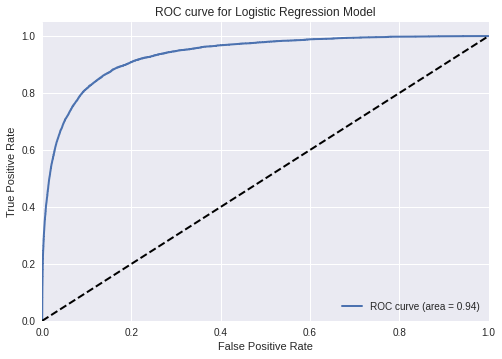

In [ ]:
fpr, tpr, thresholds = roc_curve(test_data1["target"],pred_prob)
auc_score = auc(fpr,tpr)
plt.plot(fpr,tpr,lw=2,label="ROC curve (area = %0.2f)" % auc_score)
plt.plot([0, 1], [0, 1], color="black",lw=2,linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC curve for Logistic Regression Model")
plt.show()

## Linear SVC model

In [ ]:
from sklearn import svm
from sklearn.svm import LinearSVC

In [ ]:
svc_pipeline = Pipeline([("preprocessor",data_preprocess()),("vectorized",TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2',max_features = 100000)),
                              ('clf', OneVsRestClassifier(LinearSVC(random_state=4), n_jobs=-1)),])
acc_scores2 = []
f1_scores2 = []
precision_scores2 = []
recall_scores2 = []

for feat in y_train.columns:
  svc_pipeline.fit(x_train,y_train[feat])
  pred_vals = svc_pipeline.predict(x_test)
  acc_scores2.append(accuracy_score(test_data1[feat],pred_vals))
  print("Accuracy score for {} : {}".format(feat,round(accuracy_score(test_data1[feat],pred_vals),4)))
  f1_scores2.append(f1_score(test_data1[feat],pred_vals,average='weighted'))
  precision_scores2.append(precision_score(test_data1[feat],pred_vals,average="weighted"))
  recall_scores2.append(recall_score(test_data1[feat],pred_vals,average="weighted"))

Initialized preprocessing


In [ ]:
acc_scores2 = [round(i,4) for i in acc_scores2]
f1_scores2 = [round(i,4) for i in f1_scores2]
precision_scores2 = [round(i,4) for i in precision_scores2]
recall_scores2 = [round(i,4) for i in recall_scores2]

print("Test Accuracy scores for 6 labels : {}\n".format(acc_scores2))
print("Weighted F1 scores scores for 6 labels : {}\n".format(f1_scores2))
print("Weighted Precision scores for 6 labels : {}\n".format(precision_scores2))
print("Weighted Recall scores for 6 labels : {}\n".format(recall_scores2))

Test Accuracy scores for 6 labels : [1.0, 0.9956, 0.9934, 0.9636, 0.9976, 0.9979, 0.9482]

Weighted F1 scores scores for 6 labels : [1.0, 0.9948, 0.9915, 0.9597, 0.9967, 0.9973, 0.9428]

Weighted Precision scores for 6 labels : [1.0, 0.9949, 0.9913, 0.9598, 0.997, 0.9975, 0.9428]

Weighted Recall scores for 6 labels : [1.0, 0.9956, 0.9934, 0.9636, 0.9976, 0.9979, 0.9482]




## Multinomial Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_pipeline = Pipeline([("preprocessor",data_preprocess()),("vectorized",TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2',max_features = 100000)),
                              ('clf', OneVsRestClassifier(MultinomialNB(), n_jobs=-1)),])
acc_scores3 = []
f1_scores3 = []
precision_scores3 = []
recall_scores3 = []

for feat in y_train.columns:
  naive_pipeline.fit(x_train,y_train[feat])
  pred_vals = naive_pipeline.predict(x_test)
  print("Accuracy score for {} : {}".format(feat,round(accuracy_score(test_data1[feat],pred_vals),4)))
  f1_scores3.append(f1_score(test_data1[feat],pred_vals,average='weighted'))
  precision_scores3.append(precision_score(test_data1[feat],pred_vals,average="weighted"))
  recall_scores3.append(recall_score(test_data1[feat],pred_vals,average="weighted"))

Initialized preprocessing
Accuracy score for severe_toxicity : 1.0
Accuracy score for obscene : 0.9935
Accuracy score for identity_attack : 0.9933
Accuracy score for insult : 0.9442
Accuracy score for threat : 0.997
Accuracy score for sexual_explicit : 0.9974
Accuracy score for target : 0.9249


In [ ]:
acc_scores3 = [1.0,0.9935,0.9933,0.9442,0.997,0.9974,0.9249]
f1_scores3 = [round(i,4) for i in f1_scores3]
precision_scores3 = [round(i,4) for i in precision_scores3]
recall_scores3 = [round(i,4) for i in recall_scores3]

print("Test Accuracy scores for 6 labels : {}\n".format(acc_scores3))
print("Weighted F1 scores scores for 6 labels : {}\n".format(f1_scores3))
print("Weighted Precision scores for 6 labels : {}\n".format(precision_scores3))
print("Weighted Recall scores for 6 labels : {}\n".format(recall_scores3))

Test Accuracy scores for 6 labels : [1.0, 0.9935, 0.9933, 0.9442, 0.997, 0.9974, 0.9249]

Weighted F1 scores scores for 6 labels : [1.0, 0.9903, 0.9899, 0.9189, 0.9956, 0.9961, 0.892]

Weighted Precision scores for 6 labels : [1.0, 0.9871, 0.9866, 0.9383, 0.9941, 0.9949, 0.9233]

Weighted Recall scores for 6 labels : [1.0, 0.9935, 0.9933, 0.9442, 0.997, 0.9974, 0.9249]



In [ ]:
naive_pipeline.fit(x_train,y_train["target"])
pred_prob2 = naive_pipeline.predict_proba(x_test)[:,1]

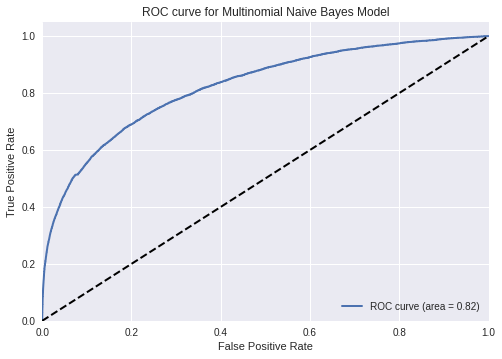

In [38]:
fpr, tpr, thresholds = roc_curve(test_data1["target"],pred_prob2)
auc_score2 = auc(fpr,tpr)
plt.plot(fpr,tpr,lw=2,label="ROC curve (area = %0.2f)" % auc_score2)
plt.plot([0, 1], [0, 1], color="black",lw=2,linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC curve for Multinomial Naive Bayes Model")
plt.show()

## XGBoost Model

In [ ]:
from xgboost.sklearn import XGBClassifier

xgb_pipeline = Pipeline([("preprocessor",data_preprocess()),("vectorized",TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2',max_features = 100000)),
                              ('clf', OneVsRestClassifier(XGBClassifier(random_state=4,max_depth=5), n_jobs=-1)),])
acc_scores4 = []
f1_scores4 = []
precision_scores4 = []
recall_scores4 = []

for feat in y_train.columns:
  xgb_pipeline.fit(x_train,y_train[feat])
  pred_vals = xgb_pipeline.predict(x_test)
  acc_scores4.append(accuracy_score(test_data1[feat],pred_vals))
  print("Accuracy score for {} : {}".format(feat,round(accuracy_score(test_data1[feat],pred_vals),4)))
  f1_scores4.append(f1_score(test_data1[feat],pred_vals,average='weighted'))
  precision_scores4.append(precision_score(test_data1[feat],pred_vals,average="weighted"))
  recall_scores4.append(recall_score(test_data1[feat],pred_vals,average="weighted"))

Initialized preprocessing


In [ ]:
acc_scores4 = [round(i,4) for i in acc_scores4]
f1_scores4 = [round(i,4) for i in f1_scores4]
precision_scores4 = [round(i,4) for i in precision_scores4]
recall_scores4 = [round(i,4) for i in recall_scores4]

print("Test Accuracy scores for 6 labels : {}\n".format(acc_scores4))
print("Weighted F1 scores scores for 6 labels : {}\n".format(f1_scores4))
print("Weighted Precision scores for 6 labels : {}\n".format(precision_scores4))
print("Weighted Recall scores for 6 labels : {}\n".format(recall_scores4))

Test Accuracy scores for 6 labels : [1.0, 0.9954, 0.9934, 0.9574, 0.9975, 0.9977, 0.9372]

Weighted F1 scores scores for 6 labels : [1.0, 0.9944, 0.9905, 0.9473, 0.9963, 0.9969, 0.9203]

Weighted Precision scores for 6 labels : [1.0, 0.9946, 0.9915, 0.9542, 0.9968, 0.9969, 0.9337]

Weighted Recall scores for 6 labels : [1.0, 0.9954, 0.9934, 0.9574, 0.9975, 0.9977, 0.9372]



In [ ]:
xgb_pipeline.fit(x_train,y_train["target"])
pred_prob1 = xgb_pipeline.predict_proba(x_test)[:,1]

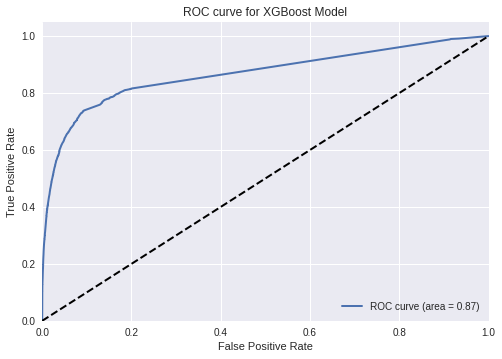

In [ ]:
fpr, tpr, thresholds = roc_curve(test_data1["target"],pred_prob1)
auc_score = auc(fpr,tpr)
plt.plot(fpr,tpr,lw=2,label="ROC curve (area = %0.2f)" % auc_score)
plt.plot([0, 1], [0, 1], color="black",lw=2,linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC curve for XGBoost Model")

plt.show()

# Plot of accuracy score comparision of models

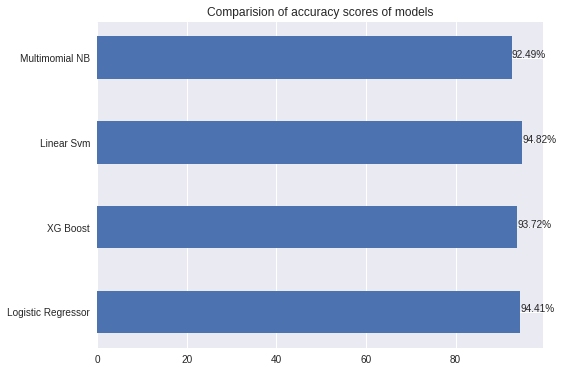

In [37]:
fig = plt.figure(figsize=(8,6))
x = ["Logistic Regressor","XG Boost","Linear Svm","Multimomial NB"]
y = [94.41,93.72,94.82,92.49]
w = 0.5
plt.barh(x,y,w)
plt.title("Comparision of accuracy scores of models")

for index, value in enumerate(y):
    plt.text(value, index,str(value)+"%")
 
plt.show()

# Sample prediction

In [ ]:
# importing the saved pipeline 
import pickle
data_filename = "/content/drive/MyDrive/toxic_comment_data/logistic_pipeline.sav"
pipeline_model = pickle.load(open(data_filename, 'rb'))

In [ ]:
# predicting the sample using saved pipeline of logistic regression
sample_text1 = pd.DataFrame(["This is what we have done."])
print("Predicted target value for the text is : {}".format(pipeline_model.predict(sample_text1)[0]))

Predicted target value for the text is : 0


In [ ]:
sample_text = pd.DataFrame(["Get the fuck out of here"])
print("Predicted target value for the text is : {}".format(pipeline_model.predict(sample_text)[0]))

Predicted target value for the text is : 1
